In [2]:
# !pip3 install shapely==2.0.0 --quiet
# !pip3 install geopandas --quiet
# !pip3 install distinctipy --quiet
# !pip3 install pickle5 --quiet
# !pip3 install networkx --quiet

In [3]:
# import warnings
# from shapely.errors import ShapelyDeprecationWarning

# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
# warnings.filterwarnings("ignore", category=UserWarning) 

In [4]:
import cv2
import pandas as pd
import pickle as pickle
import json
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry.base import BaseGeometry
from shapely import MultiPolygon, GeometryCollection, Polygon, ops, LineString, unary_union, intersection_all
from shapely import box

In [5]:
from __future__ import division
import cv2

import pandas as pd
import pickle as pickle
# import pickle5 as pickle
from collections.abc import Iterable 
from tqdm import tqdm
import os

import json
import math
import numpy as np
import shapely
from  shapely import lib, enum
from shapely.enum import ParamEnum
import pandas as pd
from pandas.core.series import Series
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

from shapely import affinity
import distinctipy
import random
from scipy.spatial.distance import euclidean

from PIL import Image
from datetime import datetime
import sklearn
import geopandas as gpd


In [6]:
with open("D:\Grad\Planify_Dataset\DataSource\Rplan_scaled.pkl", "rb") as fh:
    df = pickle.load(fh)

# Cleaning out Geometries

In [7]:
# for col in df.columns:
#     df[col] = df[col].apply(lambda x: x if x and len(x.geoms) else None)

## Data columns


In [8]:
# removed external from the list below because it causes so much trouble 
# and can be deduced from the interior area.
# df = df_orig.drop('external', axis=1)


df = df.rename(columns={
    'interior_area': 'inner',
    'exterior_wall_2': 'outer_wall',
    'interior_wall': 'inner_wall',
    'second': 'second_room'
})


geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

only_rooms =  ['living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'entrance']


needed_columns = only_rooms + ['front_door', 'interior']

df.count()

living           80788
master           80788
kitchen          80788
bathroom         80788
dining           80788
child            80788
study            80788
second_room      80788
guest            80788
balcony          80788
entrance         80788
storage          80788
wall-in          80788
exterior_wall    80788
front            80788
inner_wall       80788
interior         80788
front_door       80788
outer_wall       80788
inner            80788
area             80788
dtype: int64

In [9]:
def process_dataframe(idf):
    idf = idf.copy()
    for col in idf.columns:
        idf[col] = idf[col].apply(lambda x: x if x and len(x.geoms) else None)
    
    idf = idf.drop('external', axis=1)

    idf = idf.rename(columns={
        'interior_area': 'inner',
        'exterior_wall_2': 'outer_wall',
        'interior_wall': 'inner_wall'
    })
    return idf

# General Helper Functions

In [10]:
def plot_colors_dict(colors):
    """ Plot a dict of rooms colors
    
    Parameters
    ----------
    colors: dict
        The dict of rooms names as keys and their colors as values
        
    """
    n = len(colors)
    ncols = 4
    nrows = n // ncols + 1

    fig, ax = plt.subplots(figsize=(9, 2))

    X, Y = fig.get_dpi() * fig.get_size_inches()
    h = Y / (nrows + 1)
    w = X / ncols

    for i, name in enumerate(colors):
        col = i % ncols
        row = i // ncols
        y = Y - (row * h) - h

        xi_line = w * (col + 0.05)
        xf_line = w * (col + 0.25)
        xi_text = w * (col + 0.3)

        ax.text(xi_text, y, name, fontsize=(h * 0.8),
                horizontalalignment='left',
                verticalalignment='center')
        ax.hlines(y + h * 0.1, xi_line, xf_line,
                  color=tuple([*colors[name]/255, 1]), linewidth=(h * 0.6))

    ax.set_xlim(0, X)
    ax.set_ylim(0, Y)
    ax.set_axis_off()

    fig.subplots_adjust(left=0, right=1,
                        top=1, bottom=0,
                        hspace=0, wspace=0)
    plt.show()
    
    
def imshow(img, fig_size=(500, 500)):
    """ Plot an image
    
    Parameters
    ----------
    img: ndarray (OpenCV image) or PIL.Image
        The image to be plotted
    fig_size: tuple
        The figure size  
    """
    try:
        img = Image.fromarray(img)
    except:
        try:
            img = img.astype(np.uint8)
        except:
            ...
    display(img.resize(fig_size))

# Geometric Based Functions

In [11]:
# Generating random colors with a unified seed
random.seed(2000)
N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [12]:
def get_mask(poly, shape):
    """ Return image contains multiploygon as a numpy array mask
    
    Parameters
    ----------
    poly: Polygon or MultiPolygon or Iterable[Polygon or MultiPolygon]
        The Polygon/s to get mask for
    shape: tuple
        The shape of the canvas to draw polygon/s on
    
    Returns
    -------
    ndarray
        Mask array of the input polygon/s
        
    """
    img = np.zeros(shape, dtype=np.uint8)
    if isinstance(poly, Polygon):
        img = cv2.drawContours(img, np.int32([poly.exterior.coords]), -1, 255, -1)

    elif isinstance(poly, MultiPolygon):
        for p in poly.geoms:
            img = cv2.drawContours(img, np.int32([p.exterior.coords]), -1, 255, -1)
        
    elif isinstance(poly, Series):
        polys = [p for p in poly.tolist() if p]
        img = get_mask(polys, shape)
        
    elif isinstance(poly, Iterable):
        for p in poly:
            img = (img != 0) | (get_mask(p, shape) != 0)
        img = img.astype(np.uint8) * 255
        
    return img.astype(np.uint8)



def plot_plan_colored(index=None, idf=df, row=None, shape=(255, 255), 
                      return_img=False, points=None, radius=5, 
                      rooms_columns=geoms_columns):
    """ Plot plan given index or Series
    
    Parameters
    ----------
    index: int, optional
        The index of the plan in the Dataframe
    idf: Dataframe, optional
        The Dataframe of floor plans to index from
    row: Series, optional
        The row Series containing the plan
    shape: tuple:
        The size of the canvas to draw on
    points: list, optional:
        List of points to draw on the image
    radius: list, optional:
        Radius of points (if exists)
    rooms_columns: list, optional
        Names of rooms columns to be plotted
    """
    
    img  = np.zeros((*shape, 3), dtype=np.uint8)
    if row is None:
        if index is not None:
            row = idf.iloc[index]
        else:
            return
    
    for i, room_name in enumerate(rooms_columns):
        color = room_color[room_name]
        room_geo = row[room_name]
        if room_geo is not None:
            mask = get_mask(room_geo, shape)
            img[np.where(mask > 0)] = color
    if points:
        for p in points:
            cv2.circle(img, (int(p[0]), int(p[1])), radius, (255, 255, 255), thickness=-1)
        
    imshow(img)
    if return_img:
        return img

def plot_plan_list_colored(plan_list, shape=(255, 255), 
                      return_img=False, points=None, radius=5):
    """ Plot plan given plan list of lists: [['living', poly_livint], ['living', poly2_living]]
    
    Parameters
    ----------
    plan_list: list
        The index of the plan in the Dataframe
    shape: tuple:
        The size of the canvas to draw on
    points: list, optional:
        List of points to draw on the image
    radius: list, optional:
        Radius of points (if exists)
    """
    
    img  = np.zeros((*shape, 3), dtype=np.uint8)

    for i, (room_name, polygon) in enumerate(plan_list):
        color = room_color[room_name]
        room_geo = polygon
        if room_geo is not None:
            mask = get_mask(room_geo, shape)
            img[np.where(mask > 0)] = color
    if points:
        for p in points:
            cv2.circle(img, (int(p[0]), int(p[1])), radius, (255, 255, 255), thickness=-1)
        
    imshow(img)
    if return_img:
        return img


def get_real_area(mpoly, base_img_area=256*256, orig_area=18*18):
    """ Get real area in meters for a MultiPolygon: 
    
    Parameters
    ----------
    mpoly: MultiPolygon
        The multipolygon to get area of.
    base_img_area: int
        The area of the image this Polygon extracted from
    orig_area: int
        The scale of the base image in square meters
    """
    
    return orig_area * mpoly.area / base_img_area

In [13]:
idx = 3977

interior = df.iloc[idx]['inner']
wall = df.iloc[idx]['outer_wall']

interior_and_wall = interior.union(wall)

get_real_area(interior_and_wall)

248.81544077879923

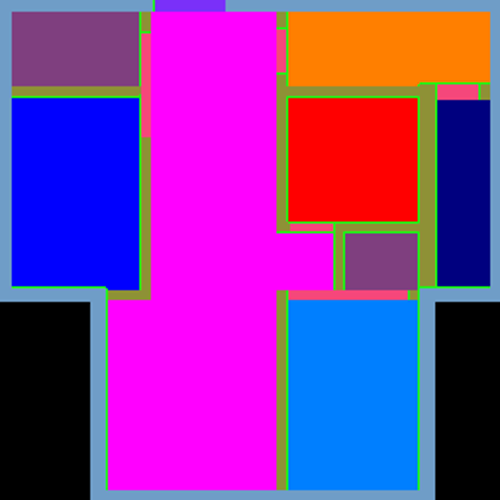

In [14]:
plot_plan_colored(900)

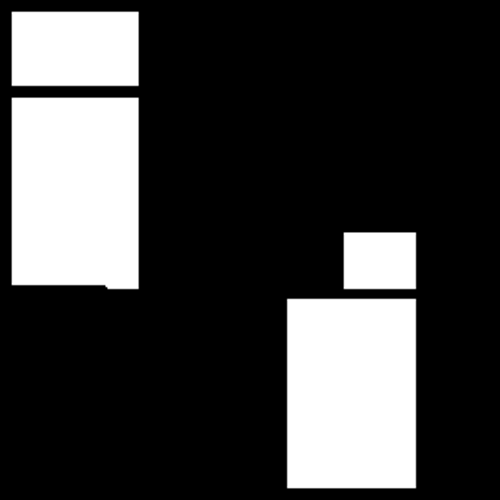

In [15]:
img = get_mask(df.iloc[900][['second_room', 'master', 'bathroom']], (256, 256))
imshow(img)

In [16]:
def rotate_polygons(polygons, degree, origin='center'):
    if isinstance(polygons, list):
        return [rotate_polygons(polygon, degree, origin) for polygon in polygons]
    elif isinstance(polygons, BaseGeometry):
        return affinity.rotate(polygons, degree, origin=origin)
    else:
        return polygons

def translate_polygons(polygons, xoff, yoff):
    if isinstance(polygons, list):
        return [translate_polygons(polygon, xoff, yoff) for polygon in polygons]
    elif isinstance(polygons, BaseGeometry):
        return affinity.translate(polygons, xoff=xoff, yoff=yoff)
    else:
        return polygons

def scale_polygons(polygons, xfact, yfact, origin='center'):
    if isinstance(polygons, list):
        return [scale_polygons(polygon, xfact, yfact, origin) for polygon in polygons]
    elif isinstance(polygons, BaseGeometry):
        return affinity.scale(polygons, xfact=xfact, yfact=yfact, origin=origin)
    else:
        return polygons

# Transforming the data

In [17]:
def get_plan(row, width, degree=0, flip_x=False, keep_padding=False):
    # https://shapely.readthedocs.io/en/stable/reference/shapely.bounds.html?highlight=bound
    # min x, min y, max x, max y.
    row = row.copy()
    
    inner = row['inner']
    inner_centroid = inner.centroid

    if degree:
        for col in geoms_columns:
            row[col] = rotate_polygons(row[col], degree, inner_centroid)
    
    inner = row['inner']
    inner_centroid = inner.centroid
    xmin, ymin, xmax, ymax = inner.bounds
    plan_width, plan_height = xmax - xmin, ymax - ymin


    # 0 for x and 1 for y
    if plan_width > plan_height:
        plan_dia = plan_width
        xtr = - xmin
        ytr = -(ymin + plan_height / 2 - plan_width / 2)
    else:
        plan_dia = plan_height
        xtr = -(xmin + plan_width / 2 - plan_height / 2)
        ytr = - ymin
    
    for col in geoms_columns:
        row[col] = translate_polygons(row[col], xtr, ytr)

    scale = width / plan_dia
    for col in geoms_columns:
        row[col] = scale_polygons(row[col], scale, scale, (0, 0))
    
    if flip_x:
        for col in geoms_columns:
            row[col] = scale_polygons(row[col], -1, 1, (width / 2, width / 2))

    return row

# Creating Graphs


In [18]:
# I noticed there is one floor plan that has no front door. Let's find it.
no_front_door = []
for i in range(df.shape[0]):
    if len(df.front_door[i].geoms) == 0:
        print(f"The floor plan that has no front door is: {i}")
        no_front_door.append(i)

The floor plan that has no front door is: 66540


In [19]:
df.drop(no_front_door[0], inplace=True)
df = df.reset_index()
# Now, number of floor plans is
df.shape[0]

80787

> Cutting the balaconies from the boundary.

In [20]:
# First let get all boundaries with balconies
with_balacony = [i for i in range(df.shape[0]) if len(df.iloc[i].balcony.geoms) > 0]

In [21]:
idx = 221
fp = df.iloc[with_balacony[idx]]

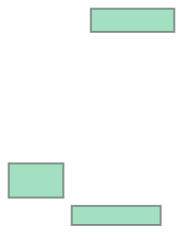

In [22]:
fp.balcony

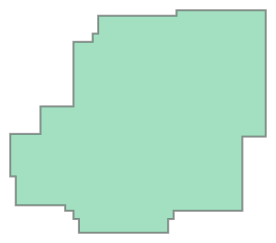

In [23]:
# The inner with the balconies
fp.inner | fp.balcony

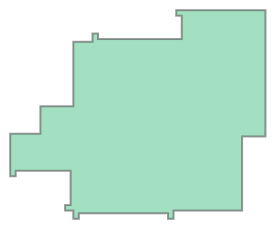

In [24]:
# the inner without the balconies but with the edges of the balconies
fp.inner - fp.balcony

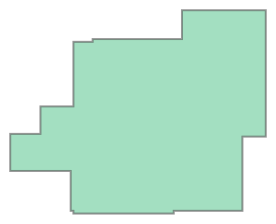

In [25]:
# With cutting the edges
(fp.inner - fp.balcony).buffer(-5, cap_style=3, join_style=2).buffer(5, cap_style=3, join_style=2)

> Now we ready to cut all balconies from the boundaries.

> Befor, The balcony edges is embedded in the boundary

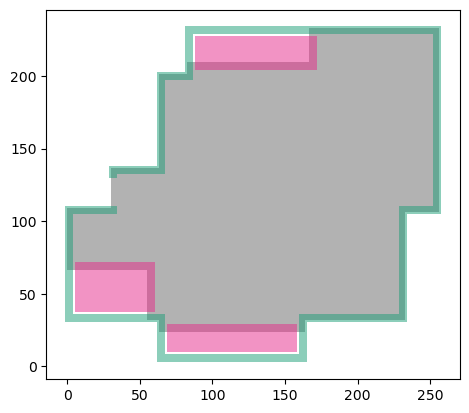

In [26]:
gpd.GeoSeries([fp.inner, fp.balcony, fp.outer_wall]).plot(cmap='Dark2_r', alpha=0.5);

In [27]:
def cut_balcony(fp, cut=3):
    new_inner =  (fp['inner'] - fp['balcony']).buffer(-cut, cap_style=3, join_style=2).buffer(cut, cap_style=3, join_style=2)
    if isinstance(new_inner, Polygon):
        return MultiPolygon([new_inner])
    else:
        return new_inner

In [28]:
df.loc[with_balacony, 'inner'] = df.loc[with_balacony].apply(lambda row: cut_balcony(row, 5), axis=1)

> After, The balcony edges is `NOT` embedded in the boundary

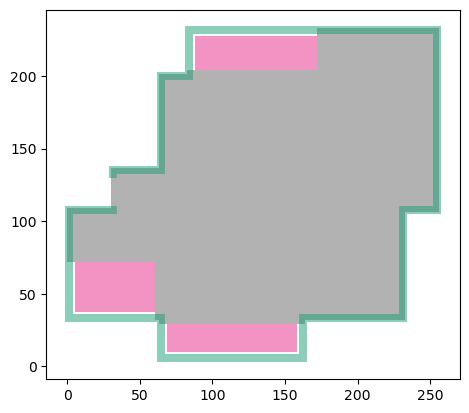

In [29]:
idx = 221
fp = df.iloc[with_balacony[idx]]
gpd.GeoSeries([fp.inner, fp.balcony, fp.outer_wall]).plot(cmap='Dark2_r', alpha=0.5);

> Creating a dic of needed columns as lists of polygons instead of multiPolygons

In [30]:
# df_rooms_polys = df[only_rooms].apply(lambda r: sum({room_name: list(mp.geoms) if mp else [] for room_name, mp in r.todict().items()})
def get_rooms_polygons(cell):
    ''' apply function for dataframe to convert MultiPolygons to a list of Polygons'''
    return list(cell.geoms) if cell is not None else []

df_rooms_polys = df[needed_columns].applymap(get_rooms_polygons)

In [31]:
def get_rooms_polygons_dict(row):
    ''' apply function for dataframe toa get dict of rooms and their polygons'''
    return row.to_dict()

df_rooms_polys_dict = df_rooms_polys.apply(get_rooms_polygons_dict, axis=1)

In [32]:
# embedding room type as intergers
embedings = {}
for i, type_ in enumerate(df_rooms_polys_dict[0].keys()):
    embedings[type_] = i
embedings

{'living': 0,
 'master': 1,
 'kitchen': 2,
 'bathroom': 3,
 'dining': 4,
 'child': 5,
 'study': 6,
 'second_room': 7,
 'guest': 8,
 'balcony': 9,
 'storage': 10,
 'entrance': 11,
 'front_door': 12,
 'interior': 13}

In [33]:
def createGraph(Graph_index, living_to_all=False, all_conected=False):
    """
    Generating a graph for a specific floor plan
    
    Input: 
        Graph_index: Index of the floo plan.
    
    Output:
        G: a networkx graph.
        
    """
    # floor_plan: a dictionary [key: type of room, value: its data]
    floor_plan = df_rooms_polys_dict[Graph_index]
    
    # Creating new graph
    G = nx.Graph()
    
    # getting the threshould of buffering each room with the inner_doors sizes to see its Adjs.
    n = len(floor_plan['interior'])
    summation = 0 
    if n != 0: # if there are inner doors
        for i in range(n):
            x1, y1, x2, y2 = floor_plan['interior'][i].bounds
            res1, res2 = x2 - x1, y2 - y1
            summation += min(res1, res2)
            
    else: # if there is no inner doors, take the outer.
        n = 1
        x1, y1, x2, y2 = floor_plan['front_door'][0].bounds
        res1, res2 = x2 - x1, y2 - y1
        summation += min(res1, res2)
    
    threshold = summation / n

    # Embeding each room in a node.
    for type_, mPoly in floor_plan.items():
        # Not encloding balcony as the model of getting centroids doesn't support balconies
        if (len(mPoly) == 0) or (type_ in ['interior', 'front_door', 'balcony', 'storage', 'entrance']):
            continue
            
        else:
            for i, poly1 in enumerate(mPoly):
                
                # x_min, y_min, x_max, y_max= poly1.bounds
                # rec_w, rec_h = x_max - x_min, y_max - y_min
                currentNodeName = f'{type_}_{i}'
                
                # The following if statement done as the model of getting centroids doesn't support living.
                if type_ == 'living':
                    center_x = df['inner'][Graph_index].centroid.x
                    center_y = df['inner'][Graph_index].centroid.y
                    # rec_w    = df['inner'][Graph_index].bounds[2] - df['inner'][Graph_index].bounds[0]
                    # rec_h    = df['inner'][Graph_index].bounds[3] - df['inner'][Graph_index].bounds[1]
                    x_min, y_min, x_max, y_max = df['inner'][Graph_index].bounds
                    
                else:
                    center_x = poly1.centroid.coords[0][0]
                    center_y = poly1.centroid.coords[0][1]
                    # rec_w    = x_max - x_min
                    # rec_h    = y_max - y_min
                    x_min, y_min, x_max, y_max = poly1.bounds
                    
                G.add_node(currentNodeName,
                    roomType_name = type_,
                    roomType_embd = embedings[type_],
                    actualCentroid_x = center_x,
                    actualCentroid_y = center_y,
                    # rec_w            = rec_w,
                    # rec_h            = rec_h,
                    x_min            = x_min,
                    y_min            = y_min,
                    x_max            = x_max,
                    y_max            = y_max,
                    
                    roomSize = poly1.area / df['inner'][Graph_index].area)
                
                
                # Creating edges between rooms.
                if (not living_to_all) and (not all_conected) :
                    for type__, mPoly_ in floor_plan.items():
                        if (len(mPoly_) == 0) or (type__ in ['interior', 'front_door', 'balcony', 'storage', 'entrance']):
                            continue
                        else:
                    # print(type__, mPoly_, len(mPoly_))
                            for j, poly2 in enumerate(mPoly_):
                                if poly2 == poly1:
                                    continue
                                else:
                                    p1 = poly1.buffer(threshold)
                                    p2 = poly2.buffer(threshold)

                                    if p1.intersects(p2):
                                        adjNodeName = f'{type__}_{j}'

                                        dis = poly1.centroid.distance(poly2.centroid)
                                        G.add_edge(currentNodeName, adjNodeName, distance=round(dis, 3))
                                        
                                        
    # if we need to connect all rooms to the living                    
    if living_to_all: 
        living_cen = shapely.Point(G.nodes['living_0']['actualCentroid_x'], G.nodes['living_0']['actualCentroid_y'])
        for node in G.nodes():
                if G.nodes[node]['roomType_name'] != 'living':
                    point = shapely.Point(G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y'])
                    dis = living_cen.distance(point)
                    # adding edges between the living and all geoms
                    G.add_edge('living_0', node, distance=round(dis, 3))


    # if we need to connect all geoms to each others  
    if all_conected: 
        for node in G.nodes():
            current_node_centeroid = shapely.Point(G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y'])

            for other_node in G.nodes():
                if other_node != node: # for all other rooms
                    other_node_centeroid = shapely.Point(G.nodes[other_node]['actualCentroid_x'], G.nodes[other_node]['actualCentroid_y'])

                    dis = current_node_centeroid.distance(other_node_centeroid)
                    # adding edges between the the current node and the other nodes
                    G.add_edge(node, other_node, distance=round(dis, 3))

    return G

In [34]:
def draw_graph_nodes(G, living_to_all=False):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    color_map = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    edge_labels = nx.get_edge_attributes(G, 'distance')

    
    nx.draw_networkx_nodes(G, pos=pos, node_size=scales, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos, edge_color='b');
    nx.draw_networkx_labels(G, pos=pos, font_size=8);

    if living_to_all:
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    
    # # Drawing the graph inside a good boundary.
    # x_coords  = [pos[node][0] for node in pos]
    # y_coords  = [pos[node][1] for node in pos]
    # threshold = max(scales) / 100
    
    # plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)

In [35]:
def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}
    
    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]
    
    # nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)
    nx.draw_networkx_nodes(G, pos=pos, node_size=150, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos)
    
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)

> Handling existing nodes in the same place.
>
> We will use it with prints to show the idea, then creating a function to use it.

In [36]:
# Coordinates of the boundary
coords = df.inner[2].geoms[0].exterior.coords[:]

# creating points:
points = []
for p in coords:
    points.append(shapely.Point(p))

# Start of Handling
graph = nx.Graph()
graph.add_node(0, type=0, centroid=coords[0])
print('0 is Done', '\n', '='*50)

# to save the index if there is a node will not be added
current = 0
name = 1

for i in range(1, len(coords)):
    print(f'num_of_nodes: {len(graph)}')
    dis = points[i].distance(points[current])
    print(i, current, '--> ', dis )
    if dis >= 5:
        print(i, 'Done')
        graph.add_node(name, type=0, centroid=coords[i])
        current = i
        name += 1
        
    else:
        print(i, 'Not-Done')
    
    print('='*50)

    
# Checking the distance between first and last node [if the distance is small, so we will consider them the same point]
nodes_names = list(graph.nodes)
print(graph.nodes[nodes_names[0]])
print(f'Number of nodes now: {len(nodes_names)}')
first_node = shapely.Point(graph.nodes[nodes_names[0]]['centroid'])
last_node  = shapely.Point(graph.nodes[nodes_names[-1]]['centroid'])
if first_node.distance(last_node) <= 5:
    graph.remove_node(nodes_names[-1])
    nodes_names = list(graph.nodes)
    print(f'Num of nodes after removing: {len(nodes_names)}')


points = []
for node in graph:
    points.append(shapely.Point(graph.nodes[node]['centroid']))

# Adding edges between nodes.
for i in range(len(nodes_names)-1):
    dis = points[i].distance(points[i+1])
    graph.add_edge(nodes_names[i],nodes_names[i+1], distance=dis)

# Adding an edge between the last and the first nodes.
dis = points[nodes_names[0]].distance(points[nodes_names[-1]])

graph.add_edge(nodes_names[0], nodes_names[-1], distance=dis)

0 is Done 
num_of_nodes: 1
1 0 -->  19.504761904761907
1 Done
num_of_nodes: 2
2 1 -->  118.24761904761905
2 Done
num_of_nodes: 3
3 2 -->  85.33333333333334
3 Done
num_of_nodes: 4
4 3 -->  240.15238095238098
4 Done
num_of_nodes: 5
5 4 -->  67.04761904761905
5 Done
num_of_nodes: 6
6 5 -->  15.84761904761902
6 Done
num_of_nodes: 7
7 6 -->  37.7904761904762
7 Done
num_of_nodes: 8
8 7 -->  137.75238095238095
8 Done
{'type': 0, 'centroid': (118.24761904761905, 75.58095238095238)}
Number of nodes now: 9
Num of nodes after removing: 8


In [37]:
def adding_door(boundary_graph, door, points):
    
    nearest_edge = None
    nearest_dist = float('inf')
    
    dx = door.bounds[2] - door.bounds[0]
    dy = door.bounds[3] - door.bounds[1]
    door_oriantation_horizontal = dx > dy

    for edge in boundary_graph.edges():
        p1 = points[edge[0]]
        p2 = points[edge[1]]

        line = shapely.LineString([p1, p2])

        # checking the oriantation of the lines.
        p1x, p1y = p1.x, p1.y
        p2x, p2y = p2.x, p2.y
        dx = abs(p2x - p1x)
        dy = abs(p2y - p1y)
        line_oriantation_horizontal = dx > dy
        
#         print(f'edge: {edge}, line is: {line_oriantation_horizontal}, door is: {door_oriantation_horizontal}')
        if door_oriantation_horizontal == line_oriantation_horizontal:
            # getting nearest - with same oriantation - edge
            dist = door.distance(line)
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_edge = edge

#     print(f'nearest is: {nearest_edge}')
    boundary_graph.remove_edge(*nearest_edge)
    
    door_ind = len(boundary_graph)
#     door_centroid = door.geoms[0].centroid
    door_centroid = door.centroid
    boundary_graph.add_node(door_ind, type=1, centroid=(door_centroid.x, door_centroid.y))

    dist = door_centroid.distance(shapely.Point(boundary_graph.nodes[nearest_edge[0]]['centroid']))
    boundary_graph.add_edge(nearest_edge[0], door_ind, distance=dist)

    dist = door_centroid.distance(shapely.Point(boundary_graph.nodes[nearest_edge[1]]['centroid']))
    boundary_graph.add_edge(nearest_edge[1], door_ind, distance=dist)
    
    return boundary_graph

In [38]:
def Handling_dubplicated_nodes(graphIndex_OR_userPolygon, door_as_polygon=None):
    
    """
    Generate a graph for the boundary.
    Input:
        graphIndex_OR_userCoords: If a list, so it is the user coords of his boundary.
                                  If just a number so it is the index of the floor plan in our dataset.
    Output:
        graph: Graph represents the boundary of the floor plan.
    """
    if isinstance(graphIndex_OR_userPolygon, (int, float)): # If a boundary from the dataset
        graph_index = graphIndex_OR_userPolygon
        
        """
        the comming for loop is used to handle if there is little polygons
        considered with the real boundary, so we will take the real one whidh
        has the maximum area.
        """

        max_area = 0
        multi_polygon = df.inner[graph_index].geoms
        for poly in multi_polygon:
            if poly.area > max_area:
                max_area = poly.area
                real_polygon = poly
        
        coords = real_polygon.exterior.coords[:]
        
    else: # If a boundary from the user
        coords = graphIndex_OR_userPolygon.exterior.coords[:]
        
    # creating points:
    points = []
    for p in coords:
        points.append(shapely.Point(p))
        
    graph = nx.Graph()
    # type of the node: 0 for boundary, 1 for front_door
    graph.add_node(0, type=0, centroid=coords[0])

    # to save the index if there is a node will not be added
    current = 0
    name = 1

    for i in range(1, len(coords)):
        dis = points[i].distance(points[current])

        if dis >= 5: # if the distance between the 2 nodes > 5, so we will add the new node
            # type of the node, edge = 0, front_door = 1
            graph.add_node(name, type=0, centroid=coords[i])
            current = i
            name += 1

    # Checking the distance between first and last node [if the distance is small, so we will consider them the same point]
    nodes_names = list(graph.nodes)
    first_node = shapely.Point(graph.nodes[nodes_names[0]]['centroid'])
    last_node  = shapely.Point(graph.nodes[nodes_names[-1]]['centroid'])
    if first_node.distance(last_node) <= 5:
        graph.remove_node(nodes_names[-1])
        nodes_names = list(graph.nodes)


        
    points_of_current_graph = []
    for node in graph:
        points_of_current_graph.append(shapely.Point(graph.nodes[node]['centroid']))

    # Adding edges between nodes.
    for i in range(len(nodes_names)-1):
        dis = points_of_current_graph[i].distance(points_of_current_graph[i+1])
        graph.add_edge(nodes_names[i],nodes_names[i+1], distance=dis)

    # Adding an edge between the last and the first nodes.
    dis = points_of_current_graph[nodes_names[0]].distance(points_of_current_graph[nodes_names[-1]])

    graph.add_edge(nodes_names[0], nodes_names[-1], distance=dis)
    
    # adding the front door
    if door_as_polygon is not None:
        door = door_as_polygon
        
    else:
        door = df['front_door'][graphIndex_OR_userPolygon]
    
    graph = adding_door(graph, door, points_of_current_graph)
    
    return graph

##### Testing generating graphs for rooms and boundary from Our dataset.

> Also we focus on graphs that have balaconies to show that our boundary now will path and cut this balaconies.

> Showing a graph with edges **between rooms as real**

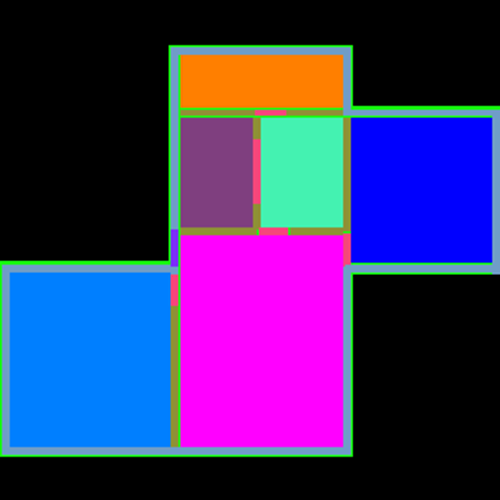

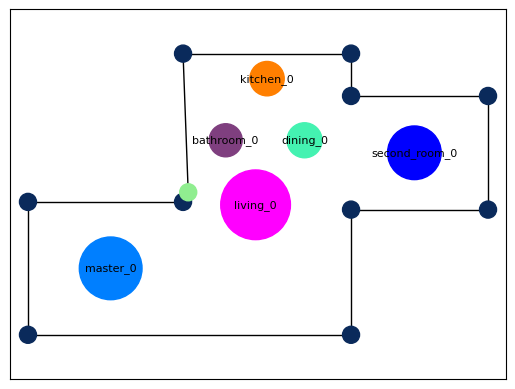

In [39]:
Graph_index = with_balacony[11]
G = createGraph(11)
b = Handling_dubplicated_nodes(11)

draw_graph_nodes(G);
plot_plan_colored(11, df);
draw_graph_boundary(b);

Showing a graph with edges **from living to all rooms**

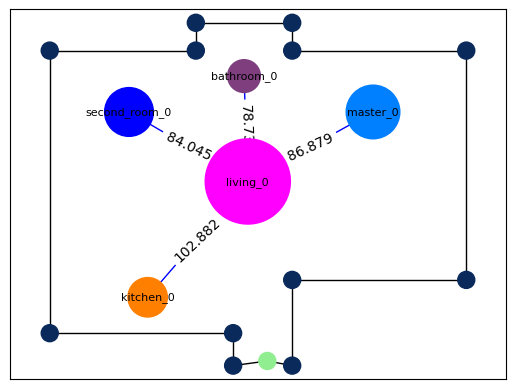

In [40]:
G_living_to_all = createGraph(Graph_index, living_to_all=True)
b = Handling_dubplicated_nodes(Graph_index)

draw_graph_nodes(G_living_to_all, living_to_all=True); 
draw_graph_boundary(b);

> Showing a graph with edges **between each room to all rooms**

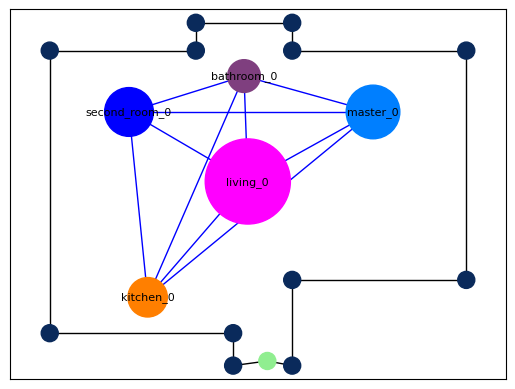

In [41]:
G_all_conected = createGraph(Graph_index, all_conected=True)
b = Handling_dubplicated_nodes(Graph_index)

draw_graph_nodes(G_all_conected); 
draw_graph_boundary(b);

##### Testing taking boundary and front door from the user, to generate a boundary graph.

In [42]:
from shapely.wkt import loads
def get_polygon_from_string(wkt):
    polygon = loads(wkt)
    return polygon

In [43]:
wkt_boundary = 'POLYGON ((25.599999999999994 65.17869060128213, 53.527272727272745 65.17869060128213, 53.527272727272745 71.38475120734273, 135.7575757575758 71.38475120734273, 135.7575757575758 79.14232696491848, 230.4 79.14232696491848, 230.4 193.9544481770397, 25.599999999999994 193.9544481770397, 25.599999999999994 65.17869060128213))'
boundary = get_polygon_from_string(wkt_boundary)

wkt_door = "POLYGON ((52.786267475558176 62.04555182296029, 27.721157248983484 62.04555182296029, 27.721157248983484 65.17869060128213, 52.786267475558176 65.17869060128213, 52.786267475558176 62.04555182296029))"
door = loads(wkt_door)

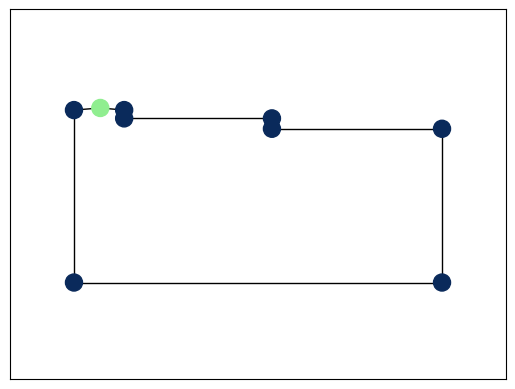

In [44]:
boundary_graph = Handling_dubplicated_nodes(boundary, door)
draw_graph_boundary(boundary_graph)

##### Testing taking from the user the rooms to generate room graph.

In [45]:
def centroids_to_graph(floor_plan, living_to_all=False, all_conected=False):
    """
    Generating a graph for a specific floor plan
    
    Input: 
        floor_plan: a dictionary [key: type of room, value: its data]
    
    Output:
        G: a networkx graph.
    """
    # Creating new graph
    G = nx.Graph()
    
    # Embeding each room in a node.
    for type_, list_of_centroids in floor_plan.items():
        
        for i, centroid in enumerate(list_of_centroids):

            currentNodeName = f'{type_}_{i}'
            G.add_node(currentNodeName,
                roomType_name = type_,
                roomType_embd = user_embedings[type_],
                actualCentroid_x = centroid[0],
                actualCentroid_y = centroid[1])
            
                                        
        # if we need to connect all rooms to the living                    
        if living_to_all: 
            living_cen = shapely.Point(G.nodes['living_0']['actualCentroid_x'], G.nodes['living_0']['actualCentroid_y'])
            for node in G.nodes():
                    if G.nodes[node]['roomType_name'] != 'living':
                        point = shapely.Point(G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y'])
                        dis = living_cen.distance(point)
                        # adding edges between the living and all geoms
                        G.add_edge('living_0', node, distance=round(dis, 3))
                        
                        
        # if we need to connect all geoms to each others  
        if all_conected: 
            for node in G.nodes():
                current_node_centeroid = shapely.Point(G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y'])

                for other_node in G.nodes():
                    if other_node != node: # for all other rooms
                        other_node_centeroid = shapely.Point(G.nodes[other_node]['actualCentroid_x'], G.nodes[other_node]['actualCentroid_y'])

                        dis = current_node_centeroid.distance(other_node_centeroid)
                        # adding edges between the the current node and the other nodes
                        G.add_edge(node, other_node, distance=round(dis, 3))

    return G

In [46]:
user_embedings = {
    'living': 0,
    'master': 1,
    'kitchen': 2,
    'bathroom': 3
    }

In [47]:
living_centroid    = [(boundary.centroid.x, boundary.centroid.y)]
room_centroids  = [(192, 164), (190, 107), (60, 165)]
bathroom_centroids = [(145, 98), (146, 172), (107, 175)]


user_data = {
    'living': living_centroid,
    'master': room_centroids,
    'bathroom': bathroom_centroids
}

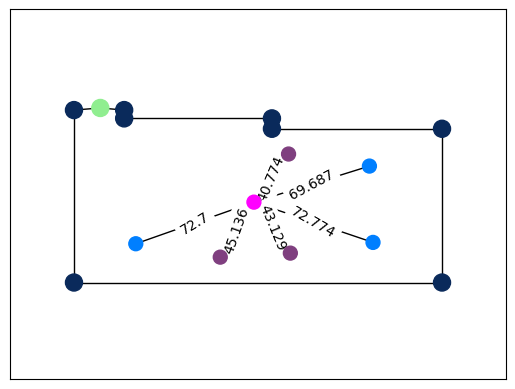

In [48]:
living_to_all = True
all_connected = False

user_G = centroids_to_graph(user_data, living_to_all=living_to_all, all_conected=all_connected)
def draw_User_graph(G, living_to_all=False):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    

    color_map = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    edge_labels = nx.get_edge_attributes(G, 'distance')

    
    nx.draw_networkx_nodes(G, pos=pos, node_size=100, node_color=color_map)
    nx.draw_networkx_edges(G, pos=pos)
    if living_to_all:
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_User_graph(user_G, living_to_all=living_to_all)
draw_graph_boundary(boundary_graph)

# Saving Graphs into pickle files

In [49]:
Graphs_real = []
Graphs_living_to_all = []
Graphs_all_conected = []
boundaries = []

errors = []
for idx in tqdm(range(len(df_rooms_polys_dict))):
    # graph as real floot plan
    try:
        G_real = createGraph(idx)

        # graph with connecting only living with all geoms
        G_living_to_all = createGraph(idx, living_to_all=True)
        
        # graph with each room connected to all others
        G_all_conected = createGraph(idx, all_conected=True)
        
        # graph of the boundary
        b = Handling_dubplicated_nodes(idx)
        
        # Graphs_real.append(G_real)
        Graphs_living_to_all.append(G_living_to_all)
        Graphs_all_conected.append(G_all_conected)
        boundaries.append(b)
    except:
        print(f'Error in getting the boundary of {idx}')
        errors.append(idx)

100%|██████████| 80787/80787 [14:55<00:00, 90.19it/s]  


> Found the index 66540 just have error in getting the door.

In [58]:
print(f"There are {len(errors)} errors in generating graphs from {len(df_rooms_polys_dict)} floor plans")

There are 0 errors in generating graphs from 80787 floor plans


In [59]:
len(Graphs_real), len(Graphs_living_to_all), len(Graphs_all_conected), len(boundaries)

(0, 80787, 80787, 80787)

In [60]:
path = "D:\Grad\Planify_Dataset\Planify_Graphs_Scaled_coords"
if not os.path.exists(path):
    os.makedirs(path)
    
print(os.getcwd())

d:\Grad\Graph-Neural-Networks\Creating_Dataset


In [61]:
with open(f'D:\Grad\Planify_Dataset\Planify_Graphs_Scaled/Graphs_real.pkl', 'wb') as f:
    pickle.dump(Graphs_real, f)

In [62]:
with open(f'D:\Grad\Planify_Dataset\Planify_Graphs_Scaled_coords/Graphs_living_to_all.pkl', 'wb') as f:
    pickle.dump(Graphs_living_to_all, f)

In [63]:
with open(f'D:\Grad\Planify_Dataset\Planify_Graphs_Scaled_coords/Graphs_all_conected.pkl', 'wb') as f:
    pickle.dump(Graphs_all_conected, f)

In [64]:
with open(f'D:\Grad\Planify_Dataset\Planify_Graphs_Scaled_coords/boundaries.pkl', 'wb') as f:
    pickle.dump(boundaries, f)

In [65]:
os.system(f"zip -r Planify_Graphs_Scalled D:\Grad\Planify_Dataset\Planify_Graphs_Scaled_coords")

1